In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install top2vec
!pip install top2vec[sentence_encoders]
!pip install top2vec[sentence_transformers]
!pip install top2vec[indexing]
!pip install octis
!pip install pyvis

In [ ]:
import pandas as pd
import spacy
import numpy as np
import re
from tqdm.auto import tqdm
import umap
import matplotlib.pyplot as plt
from top2vec import Top2Vec
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.dataset.dataset import Dataset
import networkx as nx
from pyvis.network import Network
from IPython.core.pylabtools import figsize

In [ ]:
df_prisoners_dilemmas = pd.read_csv('/content/gdrive/MyDrive/thesis_datasets/prisoners_dilemma/prisoners_dilemmas.csv')

In [ ]:
def removing_na(df, COLUMN):
  # remove the rows with NA
  df = df.loc[(df[COLUMN].isna() == False)]
  return df

In [ ]:
def preprocessing(df, COLUMN):
  # pre processing
  nlp = spacy.load("en_core_web_sm")
  texts = df[COLUMN]

  processed_texts = [text for text in tqdm(nlp.pipe(texts, 
                                              disable=["ner",
                                                       "parser"]),
                                          total=len(texts))]
  # lemmatizing, removing stop words and panctuation, lowercasing and taking nouns and adjectives
  lemmatized_texts = [[token.lemma_.lower() for token in doc if 
                    not token.is_punct and not token.is_stop and (token.pos_ == 'NOUN' or token.pos_ == 'ADJ')] for doc in processed_texts]
  # remove numbers
  lemmatized_texts = [[re.sub(r'^[0-9]+|^.$', '', word) for word in text] for text in lemmatized_texts]
  # remove empty values
  lemmatized_texts = [[token for token in text if token != ''] for text in lemmatized_texts]
  return lemmatized_texts

In [ ]:
df_keywords  = removing_na(df_prisoners_dilemmas, COLUMN = 'keywords')
lemmatized_keywords = preprocessing(df_keywords, COLUMN = 'keywords')

  0%|          | 0/1729 [00:00<?, ?it/s]

In [ ]:
df_abstracts  = removing_na(df_prisoners_dilemmas, COLUMN = 'abstract')
lemmatized_abstracts = preprocessing(df_abstracts, COLUMN = 'abstract')

  0%|          | 0/2004 [00:00<?, ?it/s]

# KEYWORDS

In [ ]:
list_keywords = df_keywords['keywords'].to_list()

In [ ]:
model_keywords = Top2Vec(list_keywords, embedding_model='universal-sentence-encoder',ngram_vocab= True, speed="deep-learn", workers=8)

2022-06-20 11:41:26,631 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2022-06-20 11:41:27,111 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2022-06-20 11:41:35,090 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-06-20 11:41:36,474 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-06-20 11:41:49,788 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-06-20 11:41:49,909 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
model_keywords.get_num_topics()

10

In [ ]:
topic_words_key, word_scores_key, topic_nums_key = model_keywords.get_topics()


In [ ]:
len(model_keywords.doc_top)

1729

In [ ]:
keywords_embeddings =  model_keywords.document_vectors

In [ ]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(keywords_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = pd.Series(model_keywords.doc_top)

In [ ]:
topics_labels_keywords_df = pd.DataFrame(result.groupby(result['labels']).mean())
list_keywords_names = [f'{words[0]}\n{words[1]}' for words in topic_words_key]
list_names= [f"T{i}\n{list_keywords_names[i]}" for i in result['labels'].unique()]
topics_labels_keywords_df.insert(2, "names", list_names)

topics_labels_keywords_df

,x,y,names
labels,,,
0,9.756515,10.215488,T0\nprisoners dilemma\nprisoner dilemma
1,8.816853,7.342466,T1\ncooperative behavior\nconflict psychology
2,5.841391,8.212716,T2\nexperimental economics\nbehavioral economics
3,8.946685,7.855662,T5\naltruistic punishment\npunishment
4,9.940648,7.666381,T3\ncooperative behavior\nsocial
5,7.204096,9.538432,T7\nprefrontal cortex\ncognitive
6,11.101089,8.630693,T4\ncooperative behavior\nconflict psychology
7,10.577721,7.441209,T8\nnorms\nsocial
8,8.202042,7.927610,T6\nsex differences\nhuman sex


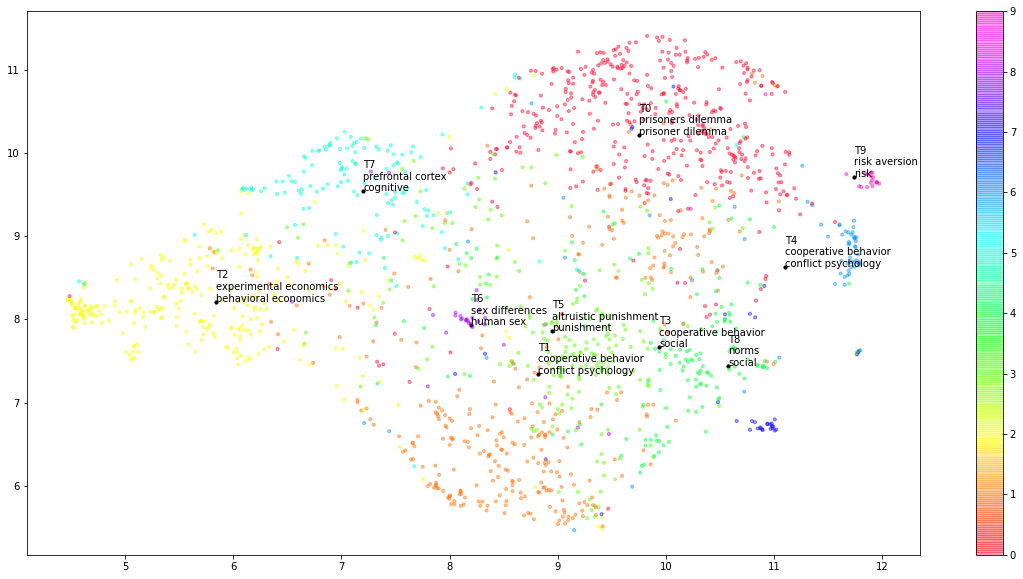

In [ ]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(topics_labels_keywords_df.x, topics_labels_keywords_df.y, s=10, color = "black")
plt.scatter(result.x, result.y, c=result.labels, s=10, cmap='gist_rainbow', alpha= 0.4)
for i, name in enumerate(topics_labels_keywords_df.names):
    plt.text(topics_labels_keywords_df.x[i],  topics_labels_keywords_df.y[i], name, fontsize = 10)
plt.colorbar()

## ABSTRACTS

In [ ]:
list_abstracts = df_prisoners_dilemmas['abstract'].to_list()

In [ ]:
model_abstracts = Top2Vec(list_abstracts, embedding_model='universal-sentence-encoder-large', 
                          min_count = 20, ngram_vocab= True, speed="deep-learn", workers=8)

2022-06-20 11:19:03,360 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2022-06-20 11:19:05,736 - top2vec - INFO - Downloading universal-sentence-encoder-large model
INFO:top2vec:Downloading universal-sentence-encoder-large model
2022-06-20 11:19:26,982 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-06-20 11:25:09,586 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-06-20 11:25:22,838 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-06-20 11:25:22,922 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
abstracts_embeddings =  model_abstracts.document_vectors

In [ ]:
model_abstracts.get_num_topics()

17

In [ ]:
topic_words_abs, word_scores, topic_nums = model_abstracts.get_topics()


In [ ]:
umap_data_ab = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(abstracts_embeddings)
result_ab = pd.DataFrame(umap_data_ab, columns=['x', 'y'])
result_ab['labels'] = pd.Series(model_abstracts.doc_top)

In [ ]:
result_ab['labels'].nunique()

17

In [ ]:
result.groupby(result_ab['labels']).mean()

,x,y,labels
labels,,,
0,8.673437,2.296478,0.829932
1,8.651860,2.001295,1.090909
2,8.487060,1.912922,1.294118
3,8.516152,2.005025,1.112676
4,8.837928,1.829545,1.213836
5,8.547147,1.918164,1.030075
6,8.559962,1.991602,1.173228
7,8.444453,1.924068,1.183206
8,8.831805,1.776078,1.220588


In [ ]:
topics_labels_abstracts_df = pd.DataFrame(result_ab.groupby(result_ab['labels']).mean())
list_abstracts_names = [f'{words[0]}\n{words[1]}' for words in topic_words_abs]
list_names= [f"T{i}\n{list_abstracts_names[i]}" for i in result_ab['labels'].unique()]
topics_labels_abstracts_df.insert(2, "names", list_names)

topics_labels_abstracts_df

,x,y,names
labels,,,
0,10.105524,7.159451,T1\nvoluntary contribution\nvoluntary contribu...
1,5.040236,7.591444,T5\nsocial cognition\npsychopathy
2,9.727157,8.780068,T10\nenvironmental uncertainty\nexternalities
3,7.382244,8.063176,T2\nprisoners dilemma\nprisoner dilemma
4,6.371129,8.107871,T12\nresource pool\nresource dilemmas
5,7.919787,9.680101,T4\ngame theoretic\nnash equilibria
6,6.656120,9.371606,T15\nleadership\nleaders
7,4.621592,9.533738,T6\nmutual cooperation\ncooperative behavior
8,7.580993,9.761371,T13\ninterpersonal trust\ntrusting behavior


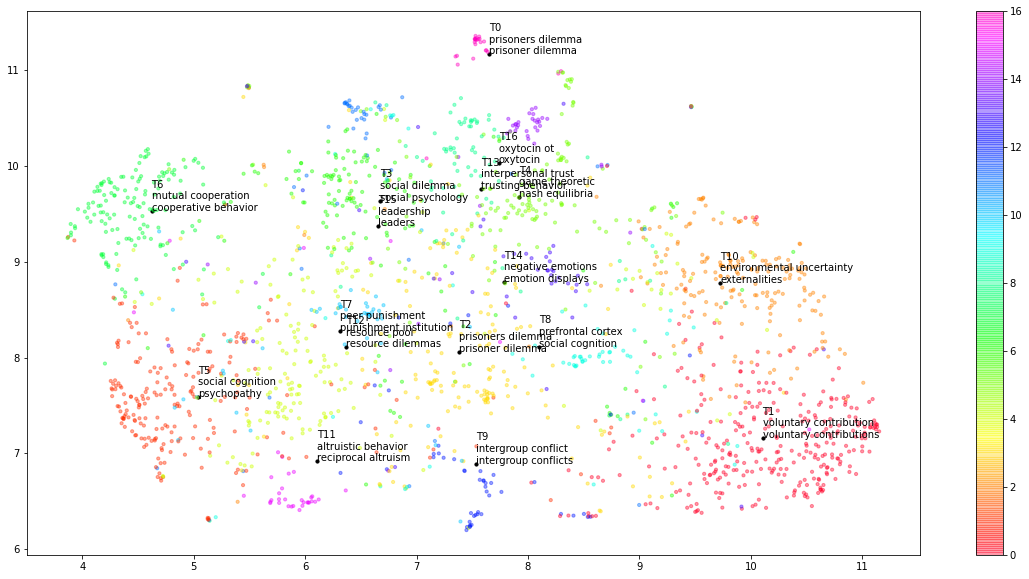

In [ ]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(topics_labels_abstracts_df.x, topics_labels_abstracts_df.y, s=10, color = "black")
plt.scatter(result_ab.x, result_ab.y, c=result_ab.labels, s=10, cmap='gist_rainbow', alpha= 0.4)
for i, name in enumerate(topics_labels_abstracts_df.names):
    plt.text(topics_labels_abstracts_df.x[i],  topics_labels_abstracts_df.y[i], name, fontsize = 10)
plt.colorbar()


# KEYWORDS COHERENCE AND DIVERSITY

In [ ]:
dataset_keywords = Dataset()
dataset_keywords.load_custom_dataset_from_folder("/content/gdrive/MyDrive/thesis_datasets/prisoners_dilemma/keywords")

In [ ]:
topics_old = [list(topic[:]) for topic in topic_words_key]
all_words = [word for words in dataset_keywords.get_corpus() for word in words]
topics = []
for topic in topics_old:
    words = []
    for word in topic:
        if word in all_words:
            words.append(word)
        else:
            print(f"error: {word}")
            words.append(all_words[0])
    topics.append(words)
output_keywords = {the
    "topics": topics,
}

error: experiment
error: experiment
error: experiment


In [ ]:
npmi_keywords = Coherence(texts=dataset_keywords.get_corpus(), topk=10, measure="c_v")
topic_diversity_keywords = TopicDiversity(topk=10)

In [ ]:
npmi_keywords.score(output_keywords)


0.39793297141178907

In [ ]:
topic_diversity_keywords.score(output_keywords)

0.58

# ABSTRACTS COHERENCE AND DIVERSITY

In [ ]:
dataset_abstracts = Dataset()
dataset_abstracts.load_custom_dataset_from_folder("/content/gdrive/MyDrive/thesis_datasets/prisoners_dilemma/abstracts")

In [ ]:
topic_words_abs, word_scores, topic_nums = model_abstracts.get_topics()


In [ ]:
topics_old = [list(topic[:]) for topic in topic_words_abs]
all_words = [word for words in dataset_abstracts.get_corpus() for word in words]
topics = []
for topic in topics_old:
    words = []
    for word in topic:
        if word in all_words:
            words.append(word)
        else:
            print(f"error: {word}")
            words.append(all_words[0])
    topics.append(words)
output_abstracts = {
    "topics": topics,
}

In [ ]:
npmi_abs = Coherence(texts=dataset_abstracts.get_corpus(), topk=10, measure="c_v")
topic_diversity_abs = TopicDiversity(topk=10)

In [ ]:
npmi_abs.score(output_abstracts)

0.8468714264007087

In [ ]:
topic_diversity_abs.score(output_abstracts)

0.1588235294117647

# NETWORKS

In [ ]:
# create df with nodes and edges
def generate_edges(topic2words):
  word2topics = {}
  for key ,values in topic2words.items():
    for value in values:
      if value in word2topics:
        word2topics[value].append(key)
      else:
        word2topics[value] = [key]

  source = []
  target = []
  for topic, words in topic2words.items():
    for word in words:
      for top in word2topics[word]:
        if top != topic:
          source.append(f"{words[0]}\n{words[1]}")
          target_words = topic2words[top]
          target.append(f"{target_words[0]}\n{target_words[1]}")


  df = pd.DataFrame()
  df['source'] = source
  df['target'] = target
  df['weight'] = 1

  return df

In [ ]:
def create_dict_top2word(topic_words):
  topic2words = {}
  for i, words in enumerate(topic_words):
      topic2words[i] = words[:5]
  return topic2words


In [ ]:
def df2network(edges_df):
  network = nx.from_pandas_edgelist(edges_df, source = 'source', target = 'target', edge_attr = 'weight',create_using=nx.MultiGraph())
  return network

## KEYWORDS NETWORK

In [ ]:
keywords_edges = generate_edges(create_dict_top2word(topic_words_key))
keywords_edges.to_csv("Top2Vec_keywords_prisoners_network.csv")

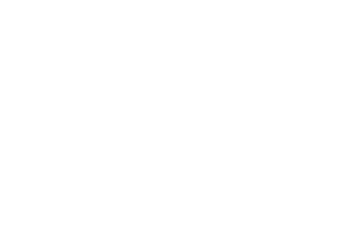

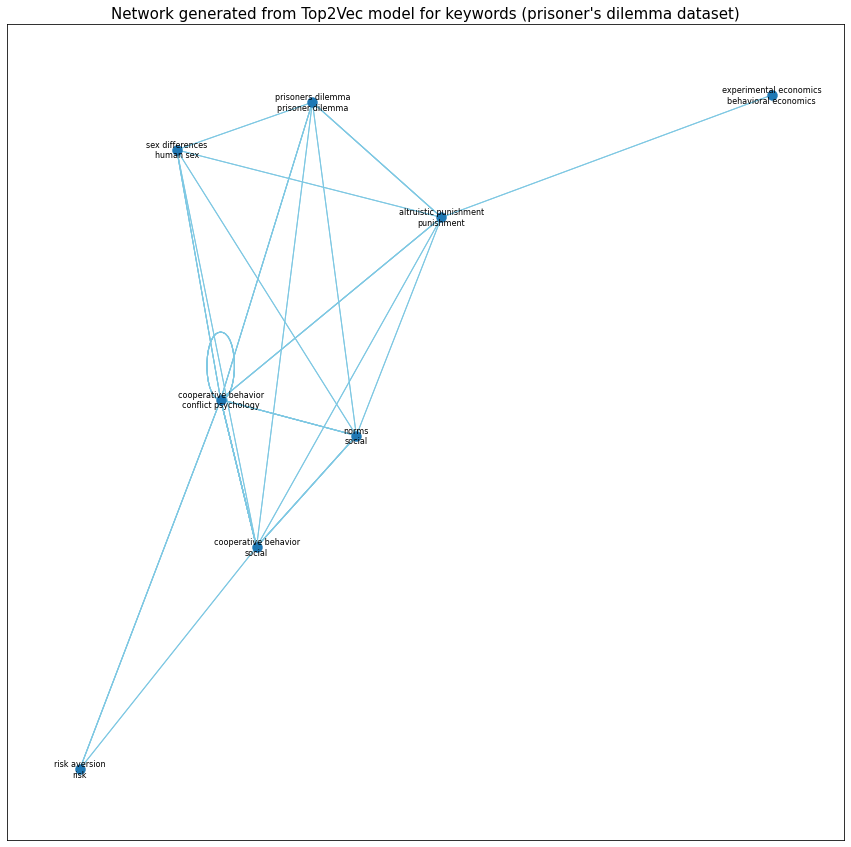

In [ ]:
#create plot 2D

limits = plt.axis("off")
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.set_title('Network generated from Top2Vec model for keywords (prisoner\'s dilemma dataset)', 
             fontdict = {'fontsize': 15})
nx.draw_networkx(df2network(keywords_edges), node_size = 100, ax = ax, 
                 edge_color = '#7EC8E3',  linewidths = 0.4, font_size = 8)
                 

In [ ]:
#create interactive plot network
net = Network(notebook=True)

net.from_nx(df2network(keywords_edges))

net.show("Top2Vec_net_keywords_prisoners.html")

## ABSTRACTS NETWORK

In [ ]:
abstracts_edges = generate_edges(create_dict_top2word(topic_words_abs))
abstracts_edges.to_csv("Top2Vec_abstracts_prisoners_network_df.csv")

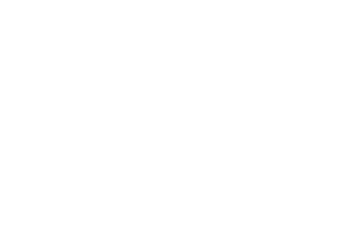

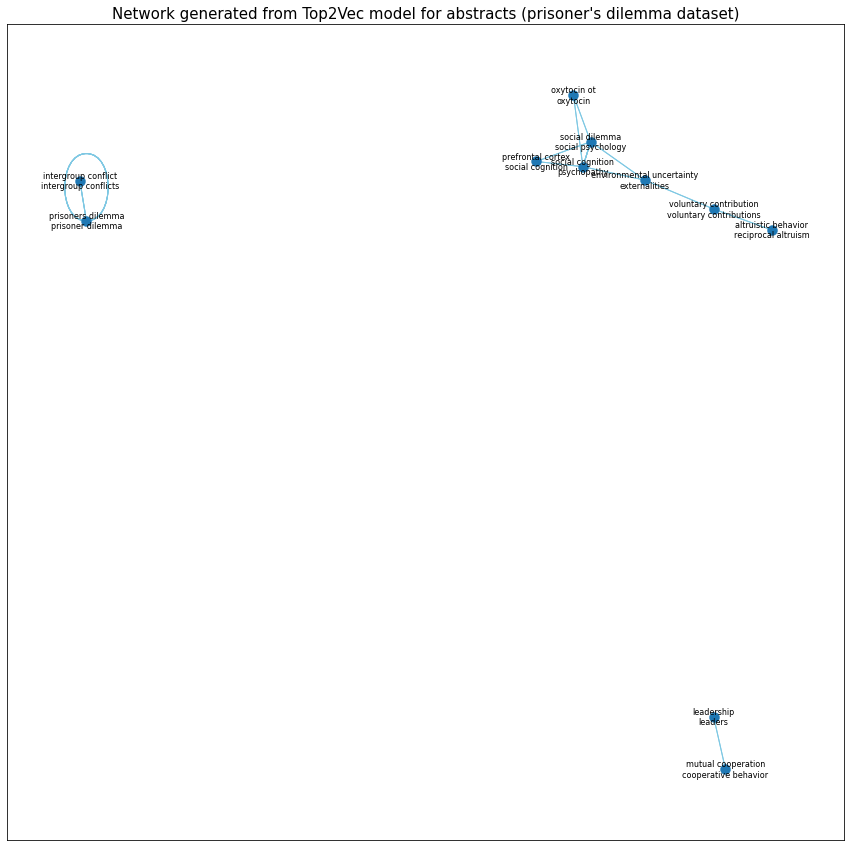

In [ ]:
# create plot 2D

limits = plt.axis("off")
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.set_title('Network generated from Top2Vec model for abstracts (prisoner\'s dilemma dataset)', 
             fontdict = {'fontsize': 15})
nx.draw_networkx(df2network(abstracts_edges), node_size = 100, ax = ax, 
                 edge_color = '#7EC8E3',  linewidths = 0.4, font_size = 8)

In [ ]:
#create interactive plot network
net = Network(notebook=True)

net.from_nx(df2network(abstracts_edges))

net.show("Top2Vec_net_abstracts_prisoners_regulation.html")